In [1]:
### Plummer Sphere Equilibrium (update) - Analysis code ### 

In [2]:
# About the code #

# The code is divided into five main Sections: 
# 1 - Setting of useful parameters
# 2 - Definition and filling of the time array 
# 3 - Energy section 
# 4 - Position section 
# 5 - Stability Section 
#
# If you want to check the initial conditions (even if it's recommended to do that in the Initial
# Condition notebook) you need only to run the Stability Section, choosing 'snapshot_to_check=0'. 
# In all the other cases, it is mandatory to run Sections 1 and 2 while the execution's order of 
# the other sections is at the user's discretion (for example, you can run section 1 and 2 and then
# run only the Position Section).

In [3]:
###################################################################################################################

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
## Section 1 - Setting of useful parameters (Nparticles,TotMass,ScaleRadiusSphere,Nsnapshots) ##

In [6]:
## Number of particles, total mass and scale radius of the sphere 
Nparticles,M,r_scale = np.loadtxt('system_properties.txt') 
Nparticles = int(Nparticles)
m = M/Nparticles # mass of a single particle

Ndimensions = 3

Nlines_in_snapshot = 3+4*Nparticles # Nparticles(1row)+Ndimensions(1)+time(1)+mass_particles(N)+
                                    # +positions(N)+velocities(N)+potential_energy(N)

In [7]:
## Reading the name of the generated files (output of 'treecode') and order them chronologically 
# (each one is the system description at a given snapshot)

import glob, os
import re # regular expression

path_data = '/home/efrem/Astronomia_extragalattica/2-NBodySimulations/6-Dinamical_Friction_(alg:treecodeBarnes)/equilibrio_senza_disturbatore/data'
data_files = []
os.chdir(path_data)
for file in glob.glob("*.data"): # selection of the directory's files that end with '.data'
    data_files.append(file)

# 'data_files' containes the name of the output 'treecode' files; each file contains the state 
# of the system at a given time; since the files in 'data_files' are not in chronologival order, 
# here a code to do that
 
def chronological_order(list):
    search_num = re.compile('(^\d+)') 
    number_to_name = []
    for i in list:
        l = search_num.search(i)
        number = int(l.group(1))
        number_to_name.append(number)
    number_to_name = sorted(number_to_name)
    # add .data
    for i in range(len(number_to_name)):
        number_to_name[i]=('{}.data'.format(number_to_name[i]))
    return (number_to_name)

data_files = chronological_order(data_files)

In [8]:
# Number of Snapshots
Nsnapshots = len(data_files)
Nsnapshots = int(Nsnapshots)

In [9]:
## Selection of the snapshots to analyze
# Here you can choose the number of snapshots that you want to analyze. The code is very performant, 
# so we suggest to analyze all of them ('step=1'). If, however, you want to select some of them you
# can modify the 'step' values or you can manually select the ones needed (commented part)

sn = 0
step = 1 # if 1, analyze all the snapshots
selected_snapshot = []
for i in range(int(Nsnapshots/step)):
    selected_snapshot.append(step*i)

# Manual selection
#selected_snapshot = [0,Nsnapshots-1] # this is an example, where we analyze the first and the last snaphots

print('The total number of snapshots is:,',Nsnapshots)
print('\nThe selected snapshots are: ',selected_snapshot)
print('\nYou want to analyze {} snapshots'.format(len(selected_snapshot)))

The total number of snapshots is:, 33

The selected snapshots are:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

You want to analyze 33 snapshots


In [10]:
###################################################################################################################

In [11]:
## Section 2 - Definition and filling of the time array ## 

In [12]:
t = np.empty([len(selected_snapshot)])
for i_snapshot in range(Nsnapshots):
    file_name = data_files[i_snapshot]
    initial_line_time = 2
    t[i_snapshot] = np.genfromtxt(file_name,skip_header=initial_line_time,max_rows=1)

In [13]:
###################################################################################################################

In [14]:
## Section 3 - Energy section 

In [15]:
# In this Section are computed, for selected snapshots, the total kinetic and the total potential energies per 
# unit mass.
# The kinetic energy, the potential energy and the total energy (sum of the previous ones) are then 
# plotted respect to time.
# The total energy, in principle, should be preserved at every time and should be equal to the total 
# energy at t=0; for this reason is presented the graph of '(Etot(t)-Etot(t=0))/Etot(t=0) vs. time' 
# that gives an idea of the conservation of energy deviation (the non perfect conservation of energy 
# is due to computational approximations)

In [16]:
velocities = np.empty([len(selected_snapshot),Nparticles,Ndimensions])

initial_line_velocity = 3+2*Nparticles
for i_snapshot in range(len(selected_snapshot)):
    file_name = data_files[selected_snapshot[i_snapshot]] 
    velocities[i_snapshot] = np.genfromtxt(file_name,skip_header=initial_line_velocity,max_rows=Nparticles)

vx = np.empty([len(selected_snapshot),Nparticles])
vy = np.empty([len(selected_snapshot),Nparticles])
vz = np.empty([len(selected_snapshot),Nparticles])
modV = np.empty([len(selected_snapshot),Nparticles]) 

for i_snapshot in range(len(selected_snapshot)):
    for i_particle in range(Nparticles):
        vx[i_snapshot,i_particle] = velocities[i_snapshot][i_particle][0]
        vy[i_snapshot,i_particle] = velocities[i_snapshot][i_particle][1]
        vz[i_snapshot,i_particle] = velocities[i_snapshot][i_particle][2]
modV = pow(vx**2+vy**2+vz**2,0.5)
        
del velocities # free up memory

In [17]:
potential_energy = np.empty([len(selected_snapshot),Nparticles])

initial_line_potential = 3+3*Nparticles
for i_snapshot in range(len(selected_snapshot)):
    file_name = data_files[selected_snapshot[i_snapshot]]
    potential_energy[i_snapshot] = np.genfromtxt(file_name,skip_header=initial_line_potential,
                                                 max_rows=Nparticles)

In [18]:
# Potential and Kinet energy per unit mass
Utot = np.sum(potential_energy,1)*0.5 # to avoid double counting
Ktot = np.sum(vx**2+vy**2+vz**2,1)*0.5

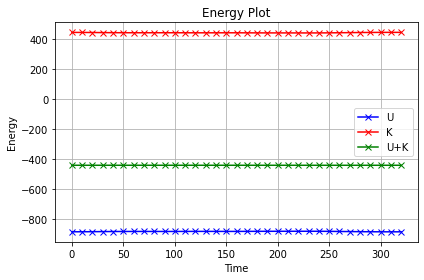

In [19]:
## Plot of the ptential energy (U), kinetic energy(K), total energy(U+K)
plt.plot(t,Utot,c='b',label='U',marker='x')
plt.plot(t,Ktot,c='r',label='K',marker='x')
plt.plot(t,Ktot+Utot,c='g',label='U+K',marker='x')

plt.title('Energy Plot')
plt.xlabel('Time')
plt.ylabel('Energy')

plt.grid()
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('energy_plot_(Np={}_M={}_Rscal={}).jpg'.format(Nparticles,M,r_scale)) 

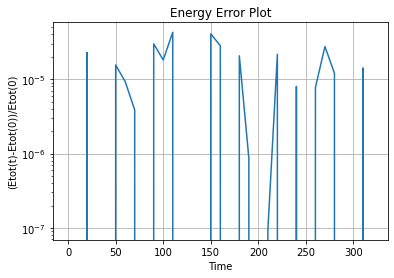

In [20]:
## Plot of '(TotalEnergy(t)-TotalEnergy(t=0))/TotalEnergy(t=0)  vs. Time'
diff = ((Utot+Ktot)-(Utot[0]+Ktot[0]))/(Utot[0]+Ktot[0])
plt.plot(t[selected_snapshot],diff)

plt.title('Energy Error Plot')
plt.xlabel('Time')
plt.ylabel('(Etot(t)-Etot(0))/Etot(0)')

plt.yscale('log')
plt.grid()
#plt.savefig('energy_diff_plot_(Np={}_M={}_Rscal={}).jpg'.format(Nparticles,M,r_scale)) 

In [21]:
###################################################################################################################

In [22]:
## Section 4 - Position section ##

In [23]:
# Subsection 1 - Lagrangian Radius #

In [24]:
# Positions
positions = np.empty([len(selected_snapshot),Nparticles,Ndimensions])

for i_snapshot in range(len(selected_snapshot)):
    file_name = data_files[selected_snapshot[i_snapshot]]
    initial_line_position = 3+Nparticles
    positions[i_snapshot] = np.genfromtxt(file_name,skip_header=initial_line_position,max_rows=Nparticles)

x = np.empty([len(selected_snapshot),Nparticles])
y = np.empty([len(selected_snapshot),Nparticles])
z = np.empty([len(selected_snapshot),Nparticles])
dist = np.empty([len(selected_snapshot),Nparticles]) # particles' distance from (0,0,0) at each time

for i_snapshot in range(len(selected_snapshot)):
    for i_particle in range(Nparticles):
        x[i_snapshot,i_particle] = positions[i_snapshot][i_particle][0]
        y[i_snapshot,i_particle] = positions[i_snapshot][i_particle][1]
        z[i_snapshot,i_particle] = positions[i_snapshot][i_particle][2]
dist = pow(x**2+y**2+z**2,0.5)
        
del positions # free up memory

In [25]:
## Lagrangian Radius of the sphere (we do not consider the perturber)

p = [20,40,60,80,90] # lagrangian radius that contain that percentage of mass

# definition of the lagrangian radius
for perc in p:
     globals()['LagRad'+str(perc)] = np.empty([len(selected_snapshot)])

sorted_distance = np.sort(dist) 

# filling of the lagrangian radius
for i_snapshot in range(len(selected_snapshot)):
    for perc in p:
         (globals()['LagRad'+str(perc)])[i_snapshot] = (sorted_distance
                                                        [i_snapshot][int(perc/100*Nparticles)-1])

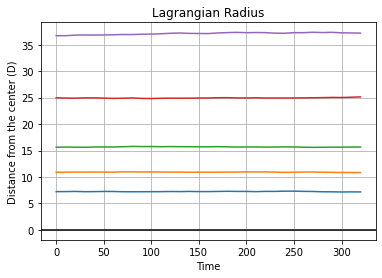

In [26]:
## Plot of the Lagrangian radius
for perc in p: 
    plt.plot(t,globals()['LagRad'+str(perc)],label='LagRad = {}%'.format(perc))

plt.axhline(0,0,1,c='k',ls='-')
    
plt.title('Lagrangian Radius')
plt.xlabel('Time')
plt.ylabel('Distance from the center (D)')

plt.grid()
#plt.legend(loc=4)
#plt.savefig('LagrangianRadius_(Np={}_M={}_Rscal={}).jpg'.format(Nparticles,M,r_scale))

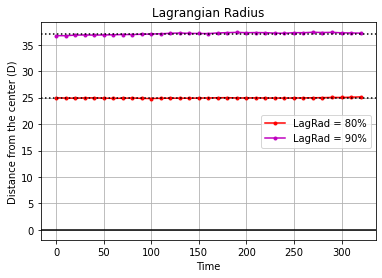

In [27]:
## Plot of only two Lagrangian radius and of the corrispondent mean (only two for a better visualization)
plt.plot(t,LagRad80,label='LagRad = 80%',marker='.',c='r')
plt.plot(t,LagRad90,label='LagRad = 90%',marker='.',c='m')

mean80 = sum(LagRad80)/len(LagRad80)
mean90 = sum(LagRad90)/len(LagRad90)
plt.axhline(mean80,0,1,c='k',ls=':')
plt.axhline(mean90,0,1,c='k',ls=':')
plt.axhline(0,0,1,c='k',ls='-')

plt.title('Lagrangian Radius')
plt.xlabel('Time')
plt.ylabel('Distance from the center (D)')

plt.grid()
plt.legend(loc='best')
#plt.savefig('LagrangianRadiusMean_(Np={}_M={}_Rscal={}).jpg'.format(Nparticles,M,r_scale)) 

In [28]:
###################################################################################################################

In [29]:
## Center of mass 

In [30]:
# N = len(selected_snapshot), R = distance vector (only particles with r<=R are considered in the 
# computation) (ex. R = LagRad80). If you want to consider all particles: 
# R = np.ones([len(selected_snapshot)])*np.max((np.sort(dist)[-1]))

def CoM(N,Nbodies,R,x,y,z,dist,mass_bodies): 
    M_tot = np.sum(mass_bodies)              
    CoM_x = np.empty([N])                   
    CoM_y = np.empty([N])
    CoM_z = np.empty([N])
    for i_snapshot in range(N):
        c_x = 0
        c_y = 0
        c_z = 0
        for i_particle in range(Nbodies): 
            if dist[i_snapshot][i_particle] <= (R[i_snapshot]):
                c_x = c_x + x[i_snapshot,i_particle]*mass_bodies[i_particle]
                c_y = c_y + y[i_snapshot,i_particle]*mass_bodies[i_particle]
                c_z = c_z + z[i_snapshot,i_particle]*mass_bodies[i_particle]
        CoM_x[i_snapshot] = c_x
        CoM_y[i_snapshot] = c_y
        CoM_z[i_snapshot] = c_z    
    CoM_x = CoM_x/M_tot
    CoM_y = CoM_y/M_tot
    CoM_z = CoM_z/M_tot
    dist_CoM = pow(CoM_x**2+CoM_y**2+CoM_z**2,0.5)
    return CoM_x,CoM_y,CoM_z,dist_CoM

In [31]:
mass_bodies = np.ones(Nparticles)*m

In [32]:
# CoM where all the particles are considered
R = np.ones([len(selected_snapshot)])*np.max((np.sort(dist)[-1]))
CoM_x,CoM_y,CoM_z,dist_CoM = CoM(len(selected_snapshot),Nparticles,R,x,y,z,dist,mass_bodies)
del R

In [33]:
## CoM of the sphere (only particles within LagRad90)
R = LagRad90
CoM_x2,CoM_y2,CoM_z2,dist_CoM2 = CoM(len(selected_snapshot),Nparticles,R,x,y,z,dist,mass_bodies)
del R

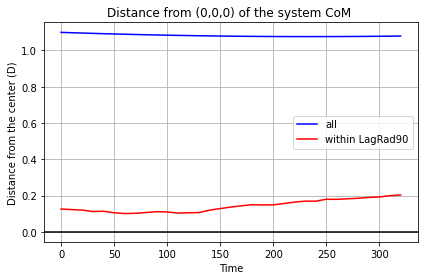

In [34]:
plt.plot(t,dist_CoM,label='all',c='b')
plt.plot(t,dist_CoM2,label='within LagRad90',c='r')

plt.axhline(0,0,1,c='k',ls='-')

plt.title('Distance from (0,0,0) of the system CoM ')
plt.xlabel('Time')
plt.ylabel('Distance from the center (D)')

plt.grid()
plt.legend()
plt.tight_layout()
#plt.savefig('CoM_tot_(Np={}_M={}_Rscal={}).jpg'.format(Nparticles,M,r_scale))

In [35]:
###################################################################################################################

In [36]:
## Angular momentum of the system

In [37]:
def angularMomentum(m,x,y,z,vx,vy,vz):
    Lx = (y*vz-z*vy)*m
    Ly = (z*vx-x*vz)*m
    Lz = (x*vy-y*vx)*m
    return Lx,Ly,Lz

In [38]:
Lx,Ly,Lz = angularMomentum(mass_bodies,x,y,z,vx,vy,vz)
Lmod_tot = pow(np.sum(Lx,1)**2+np.sum(Ly,1)**2+np.sum(Lz,1)**2,0.5)

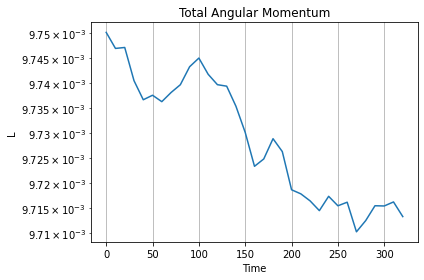

In [39]:
plt.plot(t,Lmod_tot)

plt.title('Total Angular Momentum')
plt.xlabel('Time')
plt.ylabel('L')

plt.yscale('log')
plt.grid()
plt.tight_layout()
#plt.savefig('AngMom_(Np={}_M={}_Rscal={}).jpg'.format(Nparticles,M,r_scale))

In [40]:
###################################################################################################################

In [41]:
 ## Section 5 - Stability Section ##  

In [42]:
# This Section can be used either to check if the initial conditions generated are correct 
# (the distribution of R, theta and phi, the density function and the q distribution (through 
# which you check the velocity one)) or to check at a selected snapshot if the positions and the 
# velocity distributions have changed over time or if they preserved themselves.
# To check if the intial conditions are correct choose the 'snapshot_to_check=0'.
#
# This analysis is made both qualitatively (histogram) and quantitatively (chisquare test) for 
# the R,theta and phi distributions; for the velocity distribution and for the density one it's 
# made only qualitatively.
#
# This Section is divided into three subsections:
#
# -Subsection 1: Check of the Position distribution (R,theta,phi). 
#
# -Subsection 2: Check of the Density Function. We compute the density function by dividing the sphere 
#                into shells, calculating the mass embedded in each shell (n_particles*m) and then 
#                dividing it by the shell's volume
#
# -Subsection 3: Check of the q distribution. At a snapshot different from the first one (t=0), to check 
#                if the velocity distribution is correct we derive the q values from the particles'
#                velocity and 
#                potential energy at the selected snapshot and make a normalized histogram; we then plot the 
#                theorical pdf of q and make a qualitatively comparison. 
#                For a quantitatively evaluation we need to use the chi-square, whose computation is made 
#                through the cdf of the q distribution through which one can find the expected frequencies; 
#                in this case, the cdf must be calculated numerically: this can be done but we decided to 
#                evaluate the q distribution only qualitatively.
#                If the snapshot to analyze is the first one (t=0), we compute q using the potential energy 
#                computed through the Plummer's potential and not using the 'real' one (this because the 
#                system evolution has not been already computed and so our data file do not contain the 
#                potential energy (which in principle can be computed)).
# 
# About the histograms and the statistical choices:
# - we decided to use the 'auto' number of bins selection: if the histogram is not too satisfactory 
#   or if the chi-square test is not passed, try to give manually an appropiate bin selection
# - we used a chi square distribution test to verify how well the theoretical distribution fitted 
#   the empirical ones. To use the chi-square distribution we considered only bins with a number 
#   of counts greater than 9.
# - we plot on the normalized histograms the error bars. We assume a Poissonian distribution for 
#   the counts and so the error associated to each bin is the square root of the number of counts in 
#   that bin; for the normalized histogram's error bars we rescale the error dividing it by the area
#   of the non-normalized histogram (it's maybe a non correct procedure)

In [43]:
from scipy.stats import chisquare

In [44]:
snapshot_to_check = Nsnapshots-1

In [45]:
if snapshot_to_check == 0:  
    Nparticles,M,r_scale = np.loadtxt('system_properties.txt') 
    Nparticles = int(Nparticles)
    m = M/Nparticles 
    Nlines_in_snapshot = 3+4*Nparticles 
    file_name = "initial_conditions_file.txt"
else: file_name = data_files[snapshot_to_check]

In [46]:
# Subsection 1 - Check of the Position distribution #

In [47]:
positions = np.empty([Nparticles,Ndimensions])
x1 = np.empty([Nparticles])
y1 = np.empty([Nparticles])
z1 = np.empty([Nparticles])

radius = np.empty([Nparticles]) 
theta = np.empty([Nparticles])
phi = np.empty([Nparticles])

initial_line_position = 3+Nparticles

positions = np.genfromtxt(file_name,skip_header=initial_line_position,max_rows=Nparticles)

for i_particle in range(Nparticles):
    x1[i_particle] = positions[i_particle][0]
    y1[i_particle] = positions[i_particle][1]
    z1[i_particle] = positions[i_particle][2]
    

radius = (x1**2+y1**2+z1**2)**(1/2)
theta  = np.arccos(z1/radius)
phi    = np.arctan2(y1,x1)
phi    = phi+np.pi

del positions # free up memory

In [48]:
## Radius Distribution

In [49]:
## pdf and cdf of the radial positions 
def pdf_r(r,b):
    return (3/b**3)*(r**2)*(1+(r/b)**2)**(-5/2) 
def cdf_r(b,r):
    return b**(-3)*r**3/(1+(r/b)**2)**(3/2)

In [50]:
# Chisquare Section #

empirical,edges = np.histogram(radius,bins='auto')
counts = np.copy(empirical) # used in the histogram section
theorical = []
for i_bin in range(len(empirical)):
    if empirical[i_bin]>9:
        prob = cdf_r(r_scale,edges[i_bin+1]) - cdf_r(r_scale,edges[i_bin])
        theorical.append(prob*Nparticles)        
empirical = empirical[empirical>9] 

sta, pvalue = chisquare(empirical,theorical)
if pvalue>=0.05: print('pvalue: {}, test superato'.format(pvalue))
else: print('pvalue: {}, test non superato'.format(pvalue))

pvalue: 0.34801585825474207, test superato


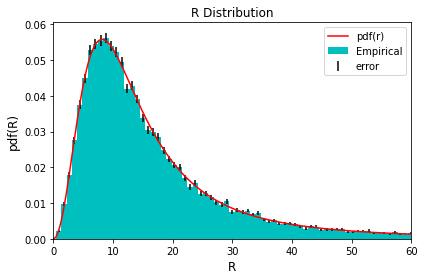

In [51]:
# Histogram Section #

# Generation of the normalized histogram and of the error bars
area = sum(np.diff(edges)*counts)
error = np.sqrt(counts) # Poissonian errors
bincenters = 0.5*(edges[1:]+edges[:-1])

normalized_counts_r, bin_edges_r, hist_r = plt.hist(radius,bins='auto',range=None,density=True,
                                                    color='c',label='Empirical')
error = np.divide(error, area) # the error bar must be rescaled since we normalized the histogram 
plt.errorbar(bincenters,normalized_counts_r,yerr=error,fmt='none',label='error',color='k')

## generation of the arrays containing some pdf's points
left_range = 0
right_range = r_scale*6
radius_pdf = np.empty(1000)
ascissa = np.linspace(left_range,right_range,1000)     
radius_pdf = pdf_r(ascissa,r_scale)

plt.plot(ascissa,radius_pdf,color='r',label='pdf(r)')
plt.xlim(left_range,right_range)

plt.title('R Distribution')
plt.xlabel('R',fontsize=12)
plt.ylabel('pdf(R)',fontsize=12)
 
plt.legend()
plt.tight_layout()
#plt.savefig('R_histo_(t={}_Np={}_M={}_Rscal={})_(pval={:3.3}).jpg'.format(t[snapshot_to_check],Nparticles,M,r_scale,pvalue)) 

# N.B. if you change the scale radius or if you want to see the whole histogram, 
# you need to do a manual rescale

In [52]:
## Phi Distribution

In [53]:
## pdf and cdf of the phi angle
def pdf_p():
    return (2*math.pi)**(-1)
def cdf_p(p):
    return p*(2*math.pi)**(-1)

In [54]:
# Chisquare Section #

empirical,edges = np.histogram(phi,bins=25)
counts = np.copy(empirical) # used in the histogram Section
theorical = []
for i_bin in range(len(empirical)):
    if empirical[i_bin]>9:
        prob = cdf_p(edges[i_bin+1]) - cdf_p(edges[i_bin])
        theorical.append(prob*Nparticles)        
empirical = empirical[empirical>9] 

sta, pvalue = chisquare(empirical,theorical)
if pvalue>=0.05: print('pvalue: {}, test superato'.format(pvalue))
else: print('pvalue: {}, test non superato'.format(pvalue))

pvalue: 0.05065754231720089, test superato


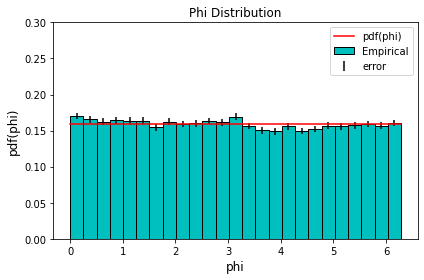

In [55]:
# Histogram Section # 

# Generation of the normalized histogram and of the error bars
area = sum(np.diff(edges)*counts)
error = np.sqrt(counts) # Poissonian errors
bincenters = 0.5*(edges[1:]+edges[:-1])

normalized_counts_p, Bin_edges_p, hist_p = plt.hist(phi,bins=25,range=None,density=True,
                                                    color='c',edgecolor='black',label='Empirical')
error = error/area # the error bar must be rescaled since we normalized the histogram 
plt.errorbar(bincenters,normalized_counts_p,yerr=error,fmt='none',label='error',color='k')

## generation of the arrays containing some pdf's points
phi_pdf = np.empty(10)
ascissa = np.linspace(0,2*math.pi,10)
phi_pdf = np.ones(10)*pdf_p()        
        
plt.plot(ascissa,phi_pdf,color='r',label='pdf(phi)')
plt.ylim(0,0.3)

plt.title('Phi Distribution') 
plt.xlabel('phi',fontsize=12)
plt.ylabel('pdf(phi)',fontsize=12)

plt.legend()
plt.tight_layout()
#plt.savefig('Phi_histo_(t={}_Np={}_M={}_Rscal={})_(pval={:3.3}).jpg'.format(t[snapshot_to_check],Nparticles,M,r_scale,pvalue)) 

In [56]:
## Theta Distribution

In [57]:
## pdf and cdf of the phi angle
def pdf_t(t):
    return 0.5*np.sin(t)
def cdf_t(t):
    return 0.5*(1-np.cos(t))

In [58]:
# Chisquare Section #

empirical,edges = np.histogram(theta,bins=44)
counts = np.copy(empirical) # used in the Histogram Section
theorical = []
for i_bin in range(len(empirical)):
    if empirical[i_bin]>9:
        prob = cdf_t(edges[i_bin+1]) - cdf_t(edges[i_bin])
        theorical.append(prob*Nparticles)        
empirical = empirical[empirical>9] 

sta, pvalue = chisquare(empirical,theorical)
if pvalue>=0.05: print('pvalue: {}, test superato'.format(pvalue))
else: print('pvalue: {}, test non superato'.format(pvalue))

pvalue: 0.0952939083548818, test superato


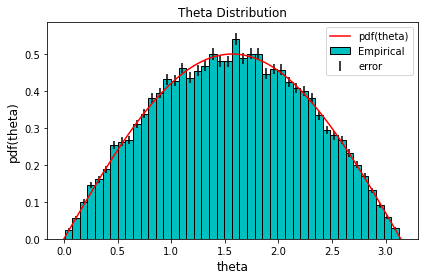

In [59]:
# Histogram Section #

# Generation of the normalized histogram and of the error bars
area = sum(np.diff(edges)*counts)
error = np.sqrt(counts) # Poissonian errors
bincenters = 0.5*(edges[1:]+edges[:-1])

normalized_counts_t, Bin_edges_t, hist_t = plt.hist(theta,bins=44,range=None,density=True,
                                                    color='c',edgecolor='black',label='Empirical')
error = error/area # the error bar must be rescaled since we normalized the histogram 
plt.errorbar(bincenters,normalized_counts_t,yerr=error,fmt='none',label='error',color='k')

## generation of the arrays containing some pdf's points
theta_pdf = np.empty(1000)
ascissa = np.linspace(0,math.pi,1000)
theta_pdf = pdf_t(ascissa)        
    
plt.plot(ascissa,theta_pdf,color='r',label='pdf(theta)')

plt.title('Theta Distribution') 
plt.xlabel('theta',fontsize=12)
plt.ylabel('pdf(theta)',fontsize=12)

plt.legend()
plt.tight_layout()
#plt.savefig('Theta_histo_(t={}_Np={}_M={}_Rscal={})_(pval={:3.3}).jpg'.format(t[snapshot_to_check],Nparticles,M,r_scale,pvalue)) 

In [60]:
# Subsection 2 - Check of the Density Function #

In [61]:
# density function
def rho(r,b,M):
    return M/(4/3*math.pi*b**3)/(1+(r/b)**2)**(5/2)

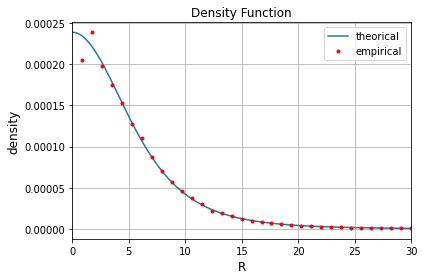

In [62]:
## generation of the theorical density
left_range = 0
right_range = 3*r_scale
density = np.empty(1000)
ascissa = np.linspace(left_range,right_range,1000)
density = rho(ascissa,r_scale,M)  
plt.plot(ascissa,density,label='theorical')

## computation of the empirical density
counts, bin_edges = np.histogram(radius, bins='auto')  
system_density = []
for i in range(len(counts)):
    system_density.append(counts[i]*m/(4/3*math.pi*(bin_edges[i+1]**3-bin_edges[i]**3)))

center = bin_edges[1::]-(bin_edges[1::]-bin_edges[:-1])/2

plt.plot(center,system_density,'r.',label='empirical')
plt.xlim(left_range,right_range)

plt.title('Density Function')
plt.xlabel('R',fontsize=12)
plt.ylabel('density',fontsize=12)

plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('density_function_(t={}_Np={}_M={}_Rscal={}).jpg'.format(t[snapshot_to_check],Nparticles,M,r_scale)) 

## N.B. in order to compute the error associated to the empirical density, one should use 
## the error propagation
## In this case we decided to evaluate the accuracy qualitatively

In [63]:
# Subsection 3 - Check of the q distribution 

In [64]:
q = np.empty([Nparticles])
initial_line_position = 3+Nparticles
initial_line_velocity = 3+2*Nparticles
initial_line_potential = 3+3*Nparticles

velocities = np.empty([Nparticles,Ndimensions])

velocities = np.genfromtxt(file_name,skip_header=initial_line_velocity,max_rows=Nparticles)

vx1 = np.empty([Nparticles])
vy1 = np.empty([Nparticles])
vz1 = np.empty([Nparticles])
modV1 = np.empty([Nparticles]) 

for i_particle in range(Nparticles):
    vx1[i_particle] = velocities[i_particle][0]
    vy1[i_particle] = velocities[i_particle][1]
    vz1[i_particle] = velocities[i_particle][2]
modV1 = pow(vx1**2+vy1**2+vz1**2,0.5)
        
del velocities # free up memory

In [65]:
rel_pot = np.empty([Nparticles])

if snapshot_to_check!=0:
    rel_pot = -1*(np.genfromtxt(file_name,skip_header=initial_line_potential,max_rows=Nparticles))   
else: 
    rel_pot = M/(radius**2+r_scale**2)**(1/2)       
    
v_max = (2*rel_pot)**(1/2)
q = modV1/v_max

In [66]:
Norm = 23.285605868167888 # normalization constant of the distribution function computed 
                          #  numerically (you can find the code at the end of this notebook)
def pdf_q(q,Norm): 
    return Norm*(1-q**2)**(7/2)*q**2
q_max = (2)**(1/2)/3  # abscissa where the distribution 'dist_func' has a maximum
f_max = pdf_q(q_max,Norm)

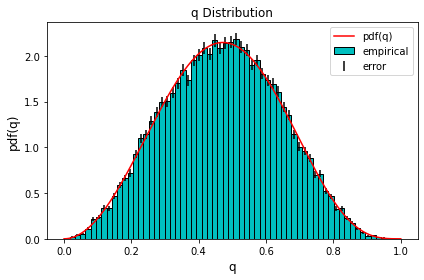

In [67]:
# Histogram Section #

counts, edges = np.histogram(q,bins='auto')
area = sum(np.diff(edges)*counts)
error = np.sqrt(counts) # Poissonian errors
bincenters = 0.5*(edges[1:]+edges[:-1])

normalized_counts_q, Bin_edges_q, hist_q = plt.hist(q,bins='auto',range=None,density=True,
                                                    color='c',edgecolor='black',label='empirical')

error = error/area # the error bar must be rescaled since we normalized the histogram 
plt.errorbar(bincenters,normalized_counts_q,yerr=error,fmt='none',label='error',color='k')

## generation of the arrays containing some pdf's points
q_pdf = np.empty(1000)
ascissa = np.linspace(0,1,1000)
q_pdf = pdf_q(ascissa,Norm)        
        
plt.plot(ascissa,q_pdf,color='r',label='pdf(q)')

plt.title('q Distribution')
plt.xlabel('q',fontsize=12)
plt.ylabel('pdf(q)',fontsize=12)

plt.legend()
plt.tight_layout()
#plt.savefig('q_histo_(t={}_Np={}_M={}_Rscal={}).jpg'.format(t[snapshot_to_check],Nparticles,M,r_scale,pvalue)) 

In [68]:
###################################################################################################################

In [ ]:
"""
## Computation of the normalization constant, N, of the distribution function f(q)=N*(1-q**2)**(7/2)*q**2
def dist_func(q):
    return (1-q**2)**(7/2)*q**2
q_max = (2)**(1/2)/3  # computing: derivative(distribution_function)=0
f_max = dist_func(q_max)
points = 1e08
points = int(points)
accepted = 0 # number of points accepted
for i in range(points):
    k1 = np.random.random() # generation of x between [0,1], interval of definition of f(q)
    k2 = np.random.random()*f_max # generation of y between [0,f_max], in the square that contains f(q)
    if k2<=dist_func(k1):
        accepted = accepted+1
f_area = (accepted/points)*(f_max*1) # fraction_accepted*area_square
f_normalization = f_area**(-1)
print('Normalization constant of the distribution function (points={}): {}'.format(points,f_normalization))
# Normalization constant of the distribution function (points=1e08): 23.285605868167888
"""

In [ ]:
'''
import time
start_time = time.time()
main()
print("--- %s seconds ---" % (time.time() - start_time))
'''